In [1]:
import pandas as pd
import sys
import numpy as np
from sklearn.preprocessing import StandardScaler
import joblib as joblib
import tensorflow as tf
from tensorflow import keras

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import model_from_json,Model, load_model
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization,Add,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback, TensorBoard

import datetime
from sklearn.model_selection import train_test_split
import os

import copy

In [2]:
os.getcwd()

'e:\\Codes\\Mantis-Shrimp-Eye-s-Collision-Avoidance\\dnn'

In [3]:
os.chdir("../")
os.getcwd()

'e:\\Codes\\Mantis-Shrimp-Eye-s-Collision-Avoidance'

In [4]:
sys.path.append(os.getcwd()+"/tools")

In [5]:
from configmanager import ConfigurationManager
configurationManager = ConfigurationManager()

## Preprocess

In [6]:
dnn_dataset =  configurationManager.config_readable['dnn_dataset']
dnn_distance_model_folder = configurationManager.config_readable['dnn_distance_model_folder']


path_dnn_train = dnn_dataset+"fake_dnn_train.csv"
path_dnn_train = dnn_dataset+"dnn_train.csv"


df_train = pd.read_csv(path_dnn_train,usecols=["object_type","width","height", "range_distance"])


df_train

,object_type,width,height,range_distance
0,Helicopter,16.000000,16.0,698.099154
1,Helicopter,16.000000,16.0,692.553591
2,Helicopter,16.000000,16.0,687.144329
3,Helicopter,16.000000,16.0,681.758264
4,Helicopter,16.000000,16.0,676.482461
...,...,...,...,...
85246,Airplane,128.000000,37.6,222.868320
85247,Airplane,134.400000,42.8,215.959436
85248,Airplane,144.200000,45.4,208.955719
85249,Airplane,137.600000,46.4,202.286877


In [7]:
df_train = df_train.sort_values('range_distance', ascending=True)
df_train

,object_type,width,height,range_distance
12737,Helicopter,143.200000,127.600000,26.440635
84744,Helicopter,26.000000,37.493372,26.686021
19451,Helicopter,123.800000,111.600000,28.485066
84743,Helicopter,337.166571,185.014409,29.873538
59041,Helicopter,65.646616,34.230769,29.919218
...,...,...,...,...
53702,Airplane,32.724304,13.083838,699.943752
73977,Helicopter,16.000000,16.000000,699.948963
60383,Helicopter,16.000000,16.000000,699.953968
66350,Helicopter,16.000000,16.000000,699.960940


In [ ]:
'''
@dataclass
class ObjectTypes(Enum):
    Airplane = 0
    Helicopter = 1
    Bird = 2
    Drone = 3
    Flock = 4
    Airborne = 5
'''

In [8]:
df_train['object_type'].replace('Airplane', 0, inplace=True)
df_train['object_type'].replace('Helicopter', 1, inplace=True)
df_train['object_type'].replace('Bird', 2, inplace=True)
df_train['object_type'].replace('Drone', 3, inplace=True)
df_train['object_type'].replace('Flock', 4, inplace=True)
df_train['object_type'].replace('Airborne', 5, inplace=True)


In [9]:
df_train.head(10)

,object_type,width,height,range_distance
12737,1,143.200000,127.600000,26.440635
84744,1,26.000000,37.493372,26.686021
19451,1,123.800000,111.600000,28.485066
84743,1,337.166571,185.014409,29.873538
59041,1,65.646616,34.230769,29.919218
12736,1,354.200000,256.000000,29.932464
58910,1,89.398281,70.456734,30.745673
54927,1,88.700565,59.875706,31.078418
50496,1,89.543478,78.275862,31.100222
51585,1,35.526316,22.368421,31.572412


In [10]:
df_train.tail(20)

,object_type,width,height,range_distance
55624,1,16.000000,16.000000,699.682960
59639,1,16.000000,16.000000,699.706057
15450,1,16.000000,16.000000,699.719229
64057,1,16.000000,16.000000,699.720929
61938,1,16.000000,16.000000,699.726700
77957,1,16.000000,16.000000,699.750331
65726,1,16.000000,16.000000,699.781889
2161,0,19.400000,6.400000,699.786453
62054,0,29.600269,7.368872,699.789544
14727,1,16.000000,16.000000,699.794274


In [8]:
'''df_train.width = df_train.width.astype(int)
df_train.height = df_train.height.astype(int)
df_train.range_distance = df_train.range_distance.astype(int)

df_train.head()'''

,object_type,width,height,range_distance
0,1,16,16,698
1,1,16,16,692
2,1,16,16,687
3,1,16,16,681
4,1,16,16,676


In [11]:
df_train.describe()

,object_type,width,height,range_distance
count,85251.000000,85251.000000,85251.000000,85251.000000
mean,0.845703,33.635859,24.376606,363.800567
std,0.361236,30.281140,18.702811,152.994637
min,0.000000,4.000000,3.200000,26.440635
25%,1.000000,16.000000,16.000000,254.307353
50%,1.000000,21.227539,18.000000,339.605495
75%,1.000000,40.538318,25.737224,472.272453
max,1.000000,375.142857,306.923077,699.963822


## Train

In [12]:
class DistanceTrain:

    def __init__(self,distance_folder_path,before_model=None,epoch=2000):

        self.path = distance_folder_path
        self.before_model = before_model
        self.epoch = epoch


    def distance_train(self, df_test):
        # ----------- import data and scaling ----------- #
        #df_train = pd.read_csv(path_dnn_train)
        #df_test = pd.read_csv(self.path + '/datasets/test.csv')

        #X_train = df_train[['xmin', 'ymin', 'xmax', 'ymax']].values
        X_train = df_test[['width', 'height', 'object_type']].values
        y_train = df_test[['range_distance']].values

        X_train, X_test, y_train, y_test = train_test_split(X_train,y_train,test_size = 0.1, random_state=123)

        #X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_train,y_train,train_size=.9, stratify=y_train)

        #X_test = df_test[['xmin', 'ymin', 'xmax', 'ymax']].values
        #y_test = df_test[['zloc']].values

        # standardized data
        x_scalar = StandardScaler()
        X_train = x_scalar.fit_transform(X_train)
        scaler_filename = self.path+"/xtrain_scaler.save"
        joblib.dump(x_scalar, scaler_filename)
        
        y_scalar = StandardScaler()
        y_train = y_scalar.fit_transform(y_train)
        scaler_filename = self.path+"/ytrain_scaler.save"
        scaler_filename = self.path+"/ytrain_scaler.save"
        joblib.dump(y_scalar, scaler_filename)
        
        # ----------- create model ----------- #
        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(128, input_dim=3, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(64, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(32, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(16, kernel_initializer='normal', activation='relu'))
        model.add(tf.keras.layers.Dense(1, kernel_initializer='normal'))

        #model = multi_gpu_model(model, gpus=2)

        initial_learning_rate = 0.1
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate,
            decay_steps=100000,
            decay_rate=0.96,
            staircase=True)
        
        opt= tf.keras.optimizers.SGD(learning_rate=lr_schedule)
        
        
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        opt = 'adam' #ilk hali
        
        
        
        model.compile(loss='mean_squared_error', optimizer=opt)

        # ----------- define callbacks ----------- #
        earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
        reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
        #modelname = "model@{}".format(int(time.time()))
        #tensorboard = TensorBoard(log_dir=path+"logs/{}".format(modelname))
        
        modelname ="model_{}".format(datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        log_dir = self.path+"/logs/fit/" + modelname
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        callbacks = [reduce_lr_loss,
                     earlyStopping,
                     tensorboard_callback]

        callbacks = [reduce_lr_loss,
                     earlyStopping]

        if self.before_model !=None:
            model.load_weights(self.path+"{}.h5".format(self.before_model))

        # ----------- start training ----------- #
        '''history = model.fit(X_train, y_train,
                                    validation_split=0.1, epochs=self.epoch, batch_size=4096,
                                    verbose=1, callbacks=callbacks,)'''
        
        history = model.fit(X_train, y_train,validation_split=0.15, epochs=self.epoch, batch_size=4096,verbose=1)

        # ----------- save model and weights ----------- #

        model.save(self.path+"{}.h5".format(modelname))
        print("model name:   "+ modelname)
        print("Saved model to disk")

In [13]:
before_model= None

epoch=1000

distance_train = DistanceTrain(distance_folder_path=dnn_distance_model_folder, before_model=before_model, epoch=epoch)
distance_train.distance_train(df_test=copy.copy(df_train))

Epoch 1/1000
16/16 [==============================] - 2s 17ms/step - loss: 0.9943 - val_loss: 0.9697
Epoch 2/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.9086 - val_loss: 0.7600
Epoch 3/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.6667 - val_loss: 0.5754
Epoch 4/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.4948 - val_loss: 0.3579
Epoch 5/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.3171 - val_loss: 0.2904
Epoch 6/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.2872 - val_loss: 0.2789
Epoch 7/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.2755 - val_loss: 0.2692
Epoch 8/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.2668 - val_loss: 0.2613
Epoch 9/1000
16/16 [==============================] - 0s 8ms/step - loss: 0.2591 - val_loss: 0.2564
Epoch 10/1000
16/16 [==============================] - 0s 7ms/step - loss: 0.2534 - val_loss: 0.249

## Prediction

In [14]:
class DistancePrediction:

    def __init__(self,distance_folder_path,model_path=None):

        self.path = distance_folder_path

        self.scalar_X = joblib.load(self.path+"/xtrain_scaler.save")
        self.scalar_y = joblib.load(self.path+"/ytrain_scaler.save")

        '''self.scalar_X_object_type = joblib.load(self.path+"/dnn/object_type_transform.save") 
        self.scalar_X_width = joblib.load(self.path+"/dnn/width_transform.save") 
        self.scalar_X_height = joblib.load(self.path+"/dnn/height_transform.save") 

        self.scalar_y = joblib.load(self.path+"/dnn/range_distance_transform.save")'''

        '''json_file = open(self.path+'/dnn/{}.json'.format(self.model), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.loaded_model = model_from_json( loaded_model_json )'''

        # load weights into new model
        self.model =keras.models.load_model(self.path+"/{}.h5".format(model_path))
        
        #self.loaded_model.load_weights(self.path+"/dnn/{}.h5".format(self.model))
        print("Loaded model from disk")

        

    def distance_data_prediction(self,df_test):
        # get data
        #df_test = pd.read_csv(self.path+'/datasets/train.csv')

        #sc = MinMaxScaler(feature_range = (0, 1))

        X_test = df_test[['width', 'height', 'object_type']].values
        print("X_test[0]",X_test[0])
        y_test = df_test[['range_distance']].values
        y_test = y_test

        # standardized data
        scalar = joblib.load(self.path+"/xtrain_scaler.save")
        X_test = scalar.transform(X_test)
        print("scalar.transform(X_test) X_test[0]",X_test[0])
        
        scalar = joblib.load(self.path+"/ytrain_scaler.save")
        y_test = scalar.transform(y_test)

        '''for col in self.df_test.columns:
            if col == "object_type":
                self.df_test[col] = self.scalar_X_object_type.transform(self.df_test[col].values.reshape(-1,1))
            elif col == "width":
                self.df_test[col] = self.scalar_X_width.transform(self.df_test[col].values.reshape(-1,1))
            elif col == "height":
                self.df_test[col] = self.scalar_X_height.transform(self.df_test[col].values.reshape(-1,1))
            elif col == "range_distance":
                self.df_test[col] = self.scalar_y.transform(self.df_test[col].values.reshape(-1,1))'''

            

        '''X_test = self.df_test[['width', 'height', 'object_type']].values
        print("X_test[0]",X_test[0])
        #X_test = self.scalar_X.transform(X_test)

        
        y_test = self.df_test[['range_distance']].values'''

        # standardized data
        #scalar = joblib.load(self.path+"/dnn/xtrain_scaler.save")
        
        print("scalar.transform(X_test) X_test[0]",X_test[0])
        
        #scalar = joblib.load(self.path+"/dnn/ytrain_scaler.save")
        #y_test = self.scalar_y.transform(y_test)

        # load json and create model
        '''json_file = open(self.path+'/dnn/{}.json'.format(self.model), 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json( loaded_model_json )'''

        # load weights into new model
        '''loaded_model.load_weights(self.path+"/dnn/{}.h5".format(self.model))
        print("Loaded model from disk")'''

        # evaluate loaded model on test data
        #loaded_model.compile(loss='mean_squared_error', optimizer='adam')
        y_pred = self.model.predict(X_test)
        print("loaded_model.predict")

        # scale up predictions to original values
        y_pred = self.scalar_y.inverse_transform(y_pred)
        print("y_pred[0]",y_pred[0])

        y_test = self.scalar_y.inverse_transform(y_test)
        print("y_test[0]",y_test[0])

        # save predictions
        df_result = df_test
        df_result['range_distance_pred'] = -100000
        df_result['score'] = -100000
        

        for idx, row in df_result.iterrows():
            #print("idx",idx)
            df_result.at[idx, 'range_distance_pred'] = int(y_pred[idx])
            df_result.at[idx, 'score'] = int(y_test[idx]-y_pred[idx])

        df_result.to_csv(dnn_dataset+'/dnn_predictions.csv', index=False)
        return df_result


    def distance_single_prediction(self,xmin, ymin, xmax, ymax, width,height,object_type):
        X_test = [[width, height, object_type]]
        #print("X_test",X_test)
        # standardized data
        #scalar = StandardScaler()
   
        X_test = self.scalar_X.transform(X_test)
        #print("scalar.transform(X_test)",X_test)

        # evaluate loaded model on test data
        #self.loaded_model.compile(loss='mean_squared_error', optimizer='adam')
        
        '''    temp = [[xmin]]
        print("temp",temp)
        temp = scalar.transform(temp)
        temp = scalar.transform(temp)
        print("scalar.transform(temp)",temp)
        temp = scalar.inverse_transform(temp)
        print("scalar.inverse_transform(temp)",temp)'''
        

        y_pred = self.model.predict(X_test)
        #print("loaded_model.predict(X_test)",y_pred)
        
        

        # scale up predictions to original values
        y_pred = self.scalar_y.inverse_transform(y_pred)
        #print("scalar.inverse_transform(y_pred)",y_pred)
        
        return y_pred[0][0]

In [15]:
model_path = "model_20230408-170519"
distance_prediction = DistancePrediction(distance_folder_path=dnn_distance_model_folder, model_path=model_path)


Loaded model from disk


### Single Prediction

In [16]:
x1_y1= (200, 200) 	
x2_y2= ( 216,216)

object_type = 1

x1=x1_y1[0]
y1=x1_y1[1]
x2=x2_y2[0]
y2=x2_y2[1]

width=x2-x1
height=y2-y1

width = 0

height = 0

distance=distance_prediction.distance_single_prediction(xmin=x1,ymin=y1,xmax=x2,ymax=y2,width= width,height=height,object_type=object_type)  #model_20200407-162540
print("distance: ", distance)

1/1 [==============================] - 0s 110ms/step
distance:  431.4662


### Test csv Prediction

In [17]:
df_train

,object_type,width,height,range_distance
12737,1,143.200000,127.600000,26.440635
84744,1,26.000000,37.493372,26.686021
19451,1,123.800000,111.600000,28.485066
84743,1,337.166571,185.014409,29.873538
59041,1,65.646616,34.230769,29.919218
...,...,...,...,...
53702,0,32.724304,13.083838,699.943752
73977,1,16.000000,16.000000,699.948963
60383,1,16.000000,16.000000,699.953968
66350,1,16.000000,16.000000,699.960940


In [18]:

predictions = distance_prediction.distance_data_prediction(df_test=copy.copy(df_train))
print(predictions)

X_test[0] [143.2 127.6   1. ]
scalar.transform(X_test) X_test[0] [3.61875113 5.51663954 0.42670352]
scalar.transform(X_test) X_test[0] [3.61875113 5.51663954 0.42670352]
2665/2665 [==============================] - 2s 761us/step
loaded_model.predict
y_pred[0] [84.11278]
y_test[0] [26.44063539]
       object_type       width      height  range_distance  \
12737            1  143.200000  127.600000       26.440635   
84744            1   26.000000   37.493372       26.686021   
19451            1  123.800000  111.600000       28.485066   
84743            1  337.166571  185.014409       29.873538   
59041            1   65.646616   34.230769       29.919218   
...            ...         ...         ...             ...   
53702            0   32.724304   13.083838      699.943752   
73977            1   16.000000   16.000000      699.948963   
60383            1   16.000000   16.000000      699.953968   
66350            1   16.000000   16.000000      699.960940   
80172            1    6

In [19]:
print(predictions['range_distance'].describe(include=['category']))

count    85251.000000
mean       363.800567
std        152.994637
min         26.440635
25%        254.307353
50%        339.605495
75%        472.272453
max        699.963822
Name: range_distance, dtype: float64


In [20]:
print(predictions['range_distance_pred'].describe(include=['category']))

count    85251.000000
mean       363.199188
std        138.089192
min         18.000000
25%        260.000000
50%        343.000000
75%        522.000000
max        653.000000
Name: range_distance_pred, dtype: float64


In [21]:
path_dnn_pred = dnn_dataset+"dnn_predictions.csv"

dnn_predictions = pd.read_csv(path_dnn_pred)
dnn_predictions

,object_type,width,height,range_distance,range_distance_pred,score
0,1,143.200000,127.600000,26.440635,213,-5
1,1,26.000000,37.493372,26.686021,522,170
2,1,123.800000,111.600000,28.485066,275,-29
3,1,337.166571,185.014409,29.873538,522,170
4,1,65.646616,34.230769,29.919218,522,-93
...,...,...,...,...,...,...
85246,0,32.724304,13.083838,699.943752,522,-129
85247,1,16.000000,16.000000,699.948963,522,45
85248,1,16.000000,16.000000,699.953968,522,-82
85249,1,16.000000,16.000000,699.960940,494,0


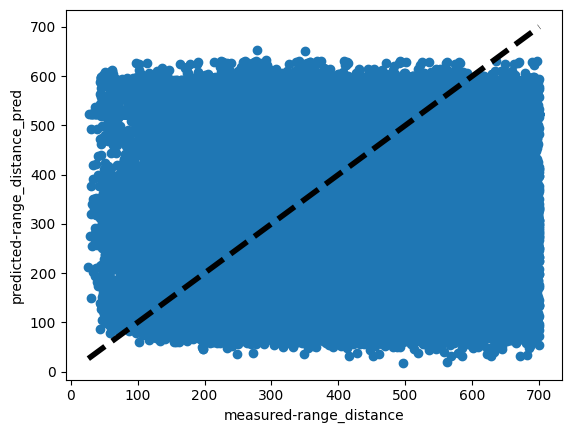

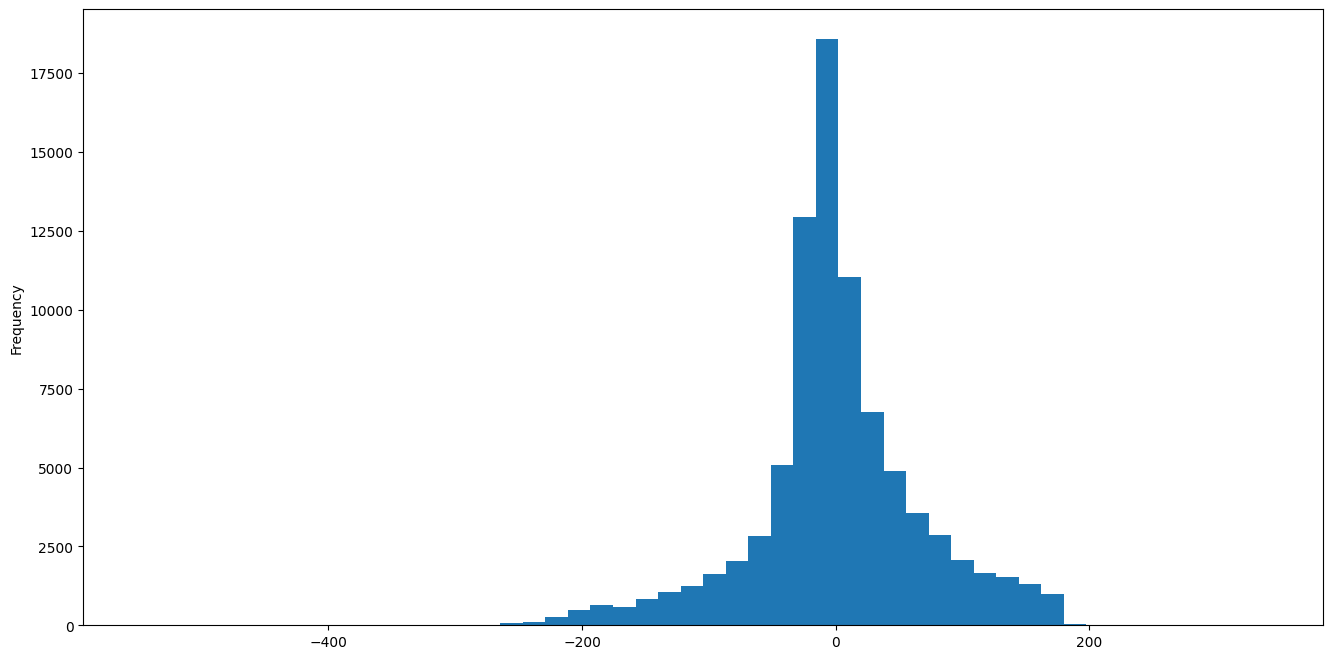

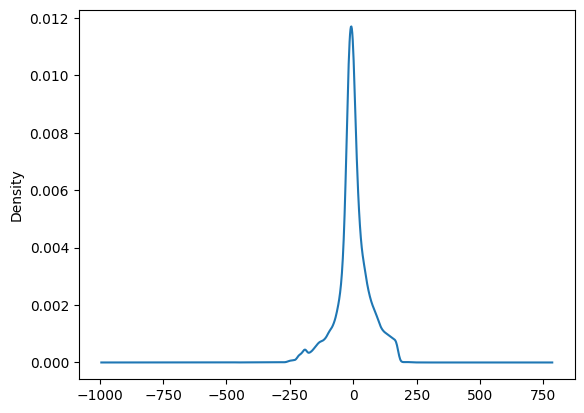

count    85251.000000
mean         0.078169
std         67.389883
min       -549.000000
25%        -25.000000
50%         -3.000000
75%         30.000000
max        340.000000
Name: score, dtype: float64


In [22]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

y_test = predictions['range_distance']
y_predicted = predictions['range_distance_pred']

ax.scatter(y_test, y_predicted)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('measured-range_distance')
ax.set_ylabel('predicted-range_distance_pred')
plt.show()


predictions['score'].plot(kind="hist", bins=50,figsize=(16,8))
plt.show()


predictions['score'].plot(kind="kde")
plt.show()

print(predictions['score'].describe(include=['category']))